# Project 4: Predict West Nile Virus
### Section 5. Model Exploration

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [1]:
#!pip install shapely
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# from shapely import geometry
# from shapely.geometry import Point, Polygon
# import geopandas as gpd
# from datetime import timedelta
# import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, classification_report, 
                             plot_roc_curve, roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score)

## Load Data

In [2]:
# Load datasets
df = pd.read_csv('../data/final_df.csv', index_col='Unnamed: 0')

In [3]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train'].copy()
test = df[df['dataset']=='test'].copy()
print(train.shape)
print(test.shape)

(8304, 240)
(43035, 240)


In [4]:
train.drop(columns='dataset', inplace=True)
test.drop(columns='dataset', inplace=True)

In [5]:
train.describe()

,latitude,longitude,tavg,preciptotal,stnpressure,resultdir,avgspeed,is_spray,stnpressure_7,stnpressure_10,...,codesum_TSRA BR HZ VCTS,codesum_TSRA FG+ BR HZ,codesum_TSRA RA,codesum_TSRA RA BR,codesum_TSRA RA BR HZ,codesum_TSRA RA BR HZ VCTS,codesum_TSRA RA BR VCTS,codesum_TSRA RA VCTS,codesum_VCTS,wnvpresent
count,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,...,8304.000000,8304.0,8304.000000,8304.000000,8304.0,8304.0,8304.000000,8304.0,8304.000000,8304.000000
mean,41.845800,-87.696229,72.093931,0.182431,29.262110,17.842245,7.476903,0.008911,29.267480,29.251286,...,0.006142,0.0,0.029383,0.037211,0.0,0.0,0.010597,0.0,0.003974,0.055034
std,0.106658,0.084440,7.630330,0.470450,0.118606,9.433945,2.543438,0.093984,0.131598,0.131994,...,0.078132,0.0,0.168889,0.189290,0.0,0.0,0.102402,0.0,0.062918,0.228060
min,41.644612,-87.930995,50.000000,0.000000,28.890000,1.000000,2.100000,0.000000,28.890000,28.920000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
25%,41.750498,-87.752411,69.000000,0.000000,29.180000,8.000000,5.800000,0.000000,29.180000,29.160000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
50%,41.862292,-87.696269,73.000000,0.000000,29.260000,19.000000,7.100000,0.000000,29.280000,29.260000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
75%,41.947227,-87.648064,78.000000,0.160000,29.340000,25.000000,9.400000,0.000000,29.340000,29.340000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
max,42.017430,-87.531635,87.000000,3.970000,29.650000,36.000000,16.300000,1.000000,29.700000,29.670000,...,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 0 to 8303
Columns: 239 entries, latitude to wnvpresent
dtypes: float64(11), int64(228)
memory usage: 15.2 MB


## Preparing Train-Test (Kaggle) Data and Further Split Train Data into Train and Holdout

In [7]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train.columns if col != 'wnvpresent']
X = train[features]
y = train['wnvpresent']

In [8]:
X.columns[X.isna().any()].tolist()

[]

In [9]:
y.value_counts(normalize = True)

0.0    0.944966
1.0    0.055034
Name: wnvpresent, dtype: float64

y is highly inbalance, with only about 6% of the data points having West Nile Virus. Hence, it is important to stratify proportionally to ensure that our train and holdout dataset have about the same proportion of presence and absence of West Nile Virus.

In [10]:
# Further split train data into train and holdout data
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, 
    y,
    stratify = y,
    random_state=42
)

## Model Exploration

### Metrics to Evaluate Models

In [18]:
# Creacting a summary dataframe.
summary_df = pd.DataFrame(columns=[
    'transformer_estimator', 
    'best_score', 
    'train_score',
    'test_score',
    'accuracy', 
    'sensitivity',
    'specificity',
    'best_params', 
])

In [19]:
summary_df

,transformer_estimator,best_score,train_score,test_score,accuracy,sensitivity,specificity,best_params


In [20]:
def model_metrics(gs_pipe, X_test, y_test):
    '''Generates confusion matrix and adds scores to summary_df'''
    #Generate confusion matrix
    y_pred = gs_pipe.predict(X_test)
    confusion_matrix(y_test, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();

    # Adding the scores into summary_df
    summary_df.loc[1] = [
        'CountVec | LogisticRegression',
        round(gs_pipe.best_score_, 3),
        round(metrics.accuracy_score(y_test, y_pred),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(tn/(tn+fp),3),
        str(gs_pipe.best_params_),
    ]

    # Plot Confusion Matrix
    plot_confusion_matrix(gs_pipe, X_test, y_test, cmap='Blues', 
                          display_labels=['WNV Present', 'WNV Not Present'],
                          normalize='true');  
    plt.title(label="Model 1: Logistic Regression", fontsize=14)
    plt.grid(False)

### Logistic Regression

In [11]:
# Instantiate model
logreg = LogisticRegression()

# Fit model
logreg.fit(X_train, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Intercept: [-0.01387925]
Logistic Regression Coefficient: [[-5.82560279e-02 -2.79590993e-02  4.25659140e-02 -1.01185717e+00
  -7.59079821e-02  1.83669797e-02 -7.52450313e-02  1.96849981e-01
   6.14443582e-02 -2.06100038e-01 -1.93653062e-01 -8.18796357e-02
  -6.35743376e-02  5.51661159e-01  3.31670682e-01 -2.53710989e-01
   0.00000000e+00  9.21340933e-02  6.20763344e-01  9.21340933e-02
  -4.84992289e-01 -2.62816456e-01  0.00000000e+00 -9.77845897e-01
   0.00000000e+00  1.12335272e-02  0.00000000e+00  1.03306527e+00
   0.00000000e+00 -3.98563017e-01 -7.72115426e-01 -6.02710932e-01
  -1.22533362e+00 -1.68839127e-01 -1.39825326e+00 -4.06870954e-01
  -4.64954065e-01  7.43667023e-01  1.38733889e+00  9.62928346e-01
   9.25535363e-01  8.40714601e-01  7.09113764e-01  1.01905010e+00
   3.43916925e-01 -8.98772554e-01 -4.06905935e-01 -4.20051579e-02
   3.13913750e-01  6.92662118e-01  3.25579306e-04  2.73620366e-01
  -2.92049231e-01 -1.30743246e+00  7.53435189e-01  0.00000000e+0

C:\Users\xiang\anaconda3\envs\dsitf\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [12]:
# Display Coefficients
coefs = pd.DataFrame({'variable':X.columns,
                            'coef':logreg.coef_[0],
                            'abs_coef':np.abs(logreg.coef_[0])
                     })

coefs.sort_values('abs_coef', inplace=True, ascending=False)
coefs.head(20)

,variable,coef,abs_coef
202,trap_T900,1.768176,1.768176
34,week_28,-1.398253,1.398253
38,week_32,1.387339,1.387339
53,species_CULEX RESTUANS,-1.307432,1.307432
32,week_26,-1.225334,1.225334
223,codesum_TS TSRA RA BR,1.201678,1.201678
27,year_2013,1.033065,1.033065
43,week_37,1.019050,1.019050
3,preciptotal,-1.011857,1.011857
23,year_2009,-0.977846,0.977846


In [13]:
# Summary scores of CountVectorizer and LogisticRegression.
print("LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe.score(X_test, y_test), 3)}")

LogisticRegression summary of accuracy scores:


NameError: name 'gs_pipe' is not defined

### Multinomial NB

### Random Forest

### SVM

### Boost

### Neutro Network

### AUC-ROC Curve

NameError: name 'cvec_lr_gs' is not defined

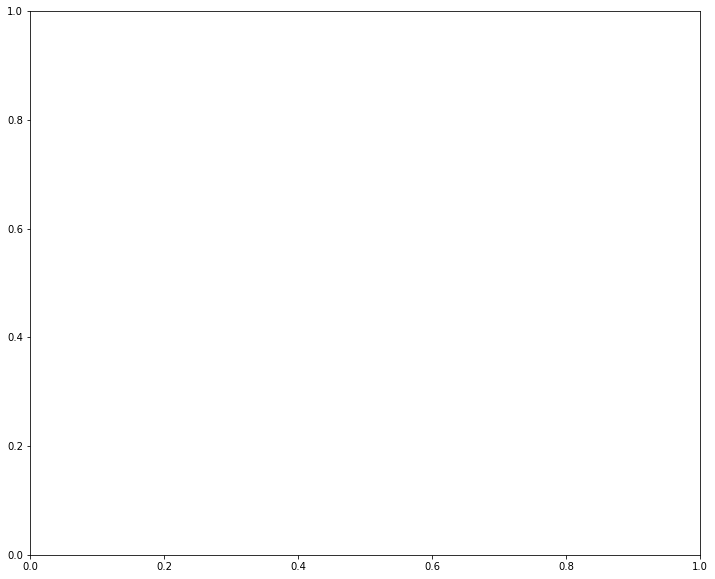

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(cvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-CVEC(GS)', color='lightgrey')
plot_roc_curve(cvec_nb_gs, X_test, y_test, ax=ax, name='MultinomialNB-CVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_svc_gs, X_test, y_test, ax=ax, name='SupportVectorClassifier-TVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-TVEC(GS)', color='blue')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend()